In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as widgvis


def load_mnist_data() -> tuple:
    """
    Load the MNIST dataset from the keras library.
    """
    X = np.load('./data/images.npy')
    X = X.reshape(70000, 784)
    y = np.load('./data/labels.npy')

    return X, y

def normalize(X:list, Y:list) -> tuple:
    """
    Normalize the dataset by dividing each pixel value by 255.
    """
    X = X/255
    Y = Y/255

    X = X - 0.5
    Y = Y - 0.5

    X = X * 2
    Y = Y * 2
    
    return X, Y

def test_train_split(X:list, Y:list, splitting_ratio:float) -> tuple:
    """
    Split the dataset into training and testing sets. 
    """
    X_train = X[:int(len(X)*splitting_ratio)]
    X_test = X[int(len(X)*splitting_ratio):]
    y_train = Y[:int(len(Y)*splitting_ratio)]
    y_test = Y[int(len(Y)*splitting_ratio):]
    return X_train, y_train, X_test, y_test

def displayImage(image:list):
    """
    Display an MNIST image.
    
    Parameters:
    -----------
    image : ndarray
        Flattened image with shape (784,)
    """
    # Reshape from (784,) to (28,28)
    img = image.reshape(28, 28)
    
    # Create a new figure with specific size
    plt.figure(figsize=(0.5, 0.5))
    
    # Display the image with grayscale colormap (similar to what's in your notebook)
    plt.imshow(img, cmap='gray')
    
    # Remove axes for cleaner display
    plt.axis('off')
    
    # Show the plot
    plt.show()

def displayImages(images, labels, grid_size):
    """
    Display multiple MNIST images in a square grid with labels below each image.
    """
    plt.figure(figsize=(grid_size, grid_size))
    
    for i in range(grid_size**2):
        # Create a subplot at the i-th position
        plt.subplot(grid_size, grid_size, i+1)
        

        random_index = np.random.randint(0, images.shape[0])
        img = images[random_index].reshape(28, 28)
        
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(labels[random_index])
    
    plt.tight_layout()
    plt.show()

def displayPredictions(images:list, labels:list, predictions:list, grid_size:int):
    """
    Display multiple MNIST images in a square grid with labels as well as predictions below each image.
    """
    plt.figure(figsize=(grid_size, grid_size))
    for i in range(grid_size**2):
        plt.subplot(grid_size, grid_size, i+1)
        random_index = np.random.randint(0, images.shape[0])
        img = images[random_index].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f'{predictions[random_index]} | {labels[random_index]}')
    plt.tight_layout()
    plt.suptitle("Prediction | Label", fontsize=16)
    plt.subplots_adjust(top=0.9)  # Add space for the title
    plt.show()
    
def DisplayErrors(images:list, labels:list, predictions:list):
    """
    Display all the MNIST images that were predicted incorrectly in a grid as well as the prediction and label below each image.
    """
    incorrect_indices = np.where(predictions != labels)[0]
    grid_size = int(np.ceil(np.sqrt(len(incorrect_indices))))
    plt.figure(figsize=(grid_size, grid_size))
    for i in range(grid_size**2):
        plt.subplot(grid_size, grid_size, i+1)
        if i < len(incorrect_indices):
            img = images[incorrect_indices[i]].reshape(28, 28)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(f'{predictions[incorrect_indices[i]]} | {labels[incorrect_indices[i]]}')
    plt.tight_layout()
    plt.show()
    print(f"Total errors: {len(incorrect_indices)} out of {len(images)}")


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from essential import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.nn import softmax

In [4]:
X, y = load_mnist_data()
X_train, y_train, X_test, y_test = test_train_split(X, y, splitting_ratio=0.8)
X_train, X_test = normalize(X_train, X_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((56000, 784), (56000,), (14000, 784), (14000,))

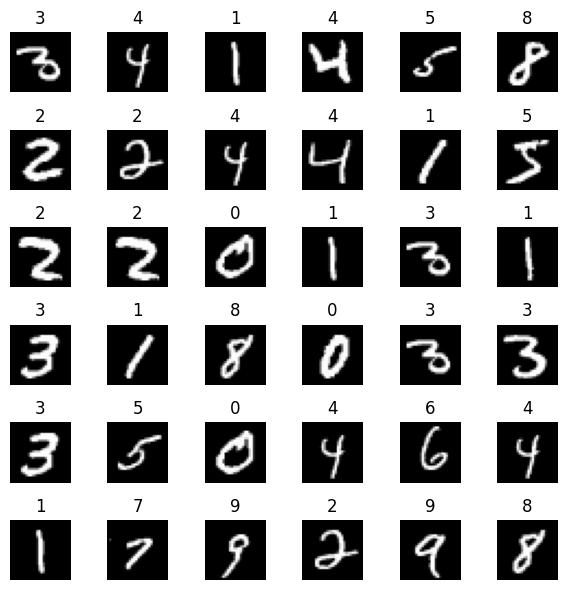

In [5]:
# random images from the dataset
displayImages(X_train[:36], y_train[:36], grid_size=6)

In [6]:
model = Sequential(
    [
        Input(shape=(784,), name='InputLayer'),
        Dense(25, activation='relu', name='L1'),
        Dense(15, activation='relu', name='L2'),
        Dense(10, activation='linear', name='L3'), # linear in order to benifit from logits
    ], name='softmax_10class_classifier'
)
model.summary()

Model: "softmax_10class_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 25)             │        19,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,175 (78.81 KB)

 Trainable params: 20,175 (78.81 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
[L1, L2, L3] = model.layers
W1, b1 = L1.get_weights()
W2, b2 = L2.get_weights()
W3, b3 = L3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


In [8]:
# %%
model.compile(
    optimizer=Adam(1e-4),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4267 - loss: 1.6345
Epoch 2/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8417 - loss: 0.5582
Epoch 3/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8850 - loss: 0.4023
Epoch 4/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8974 - loss: 0.3514
Epoch 5/5
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9063 - loss: 0.3200


In [10]:
print(f"W1 = {W1}, b1 = {b1}")
print(f"W2 = {W2}, b2 = {b2}")
print(f"W3 = {W3}, b3 = {b3}")

W1 = [[-0.08042056 -0.01976159 -0.0776821  ...  0.06356499  0.05896261
  -0.04808494]
 [ 0.02847085  0.07895236  0.01313791 ...  0.02350859  0.04645875
   0.02240199]
 [ 0.05514494 -0.02268749 -0.0337637  ... -0.04187183 -0.02640089
   0.08178513]
 ...
 [-0.0294389  -0.00972176  0.0519653  ...  0.01261576  0.05710036
  -0.07749797]
 [-0.06381315  0.04598451  0.05519986 ... -0.03330486  0.01692624
  -0.05558155]
 [ 0.05771965 -0.02975491  0.04709978 ...  0.01206932  0.04087371
  -0.02582475]], b1 = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
W2 = [[ 3.72628272e-01 -2.44743541e-01 -4.04331684e-02  1.42185986e-01
  -2.33968213e-01 -3.48617673e-01 -1.95539907e-01  3.26961279e-04
  -2.74126947e-01 -3.63287121e-01 -2.82912374e-01  9.84182656e-02
  -4.98096645e-02  2.88817167e-01 -1.79607168e-01]
 [ 1.64463103e-01 -1.35621697e-01 -9.79952514e-02 -2.36393049e-01
  -1.48405731e-02 -3.66158605e-01 -2.92231351e-01  1.72940195e-01
  -2.07919717e-01  1.66873991e-01

In [11]:
pred = model.predict(X_test)
pred = softmax(pred)
predictions = np.zeros(pred.shape[0])

for i in range(pred.shape[0]):
    predictions[i] = np.argmax(pred[i])

predictions = predictions.astype(int)
accuracy = np.mean(predictions == y_test)
print(accuracy)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
0.9208571428571428


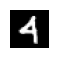

Probability Distribution : [2.8120238e-07 1.6033926e-05 2.1131898e-03 7.7926402e-04 8.9991212e-01
 1.7122143e-04 1.2025897e-03 6.1540125e-04 6.3764048e-05 9.5126152e-02]
Prediction : 4, Label : 4


In [12]:
random_index = np.random.randint(0, y_test.shape[0])
displayImage(X_test[random_index].reshape((1,784)))
print(f"Probability Distribution : {pred[random_index]}")
print(f"Prediction : {predictions[random_index]}, Label : {y_test[random_index]}")

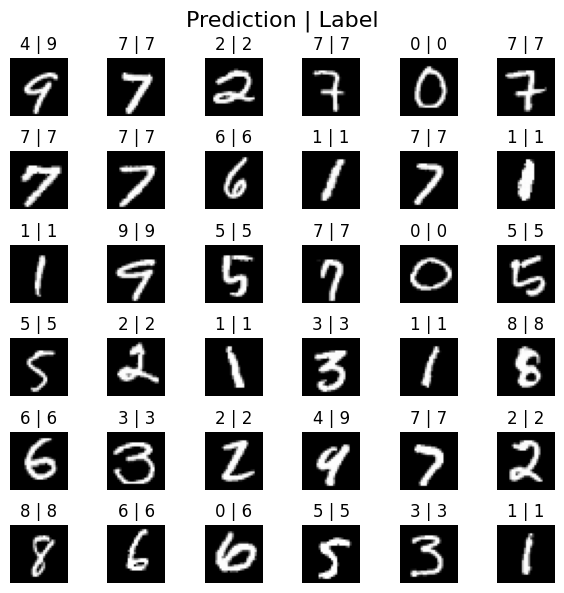

In [13]:
# display random images from the test set along with their predictions in a square grid
displayPredictions(X_test, y_test, predictions, grid_size=6)

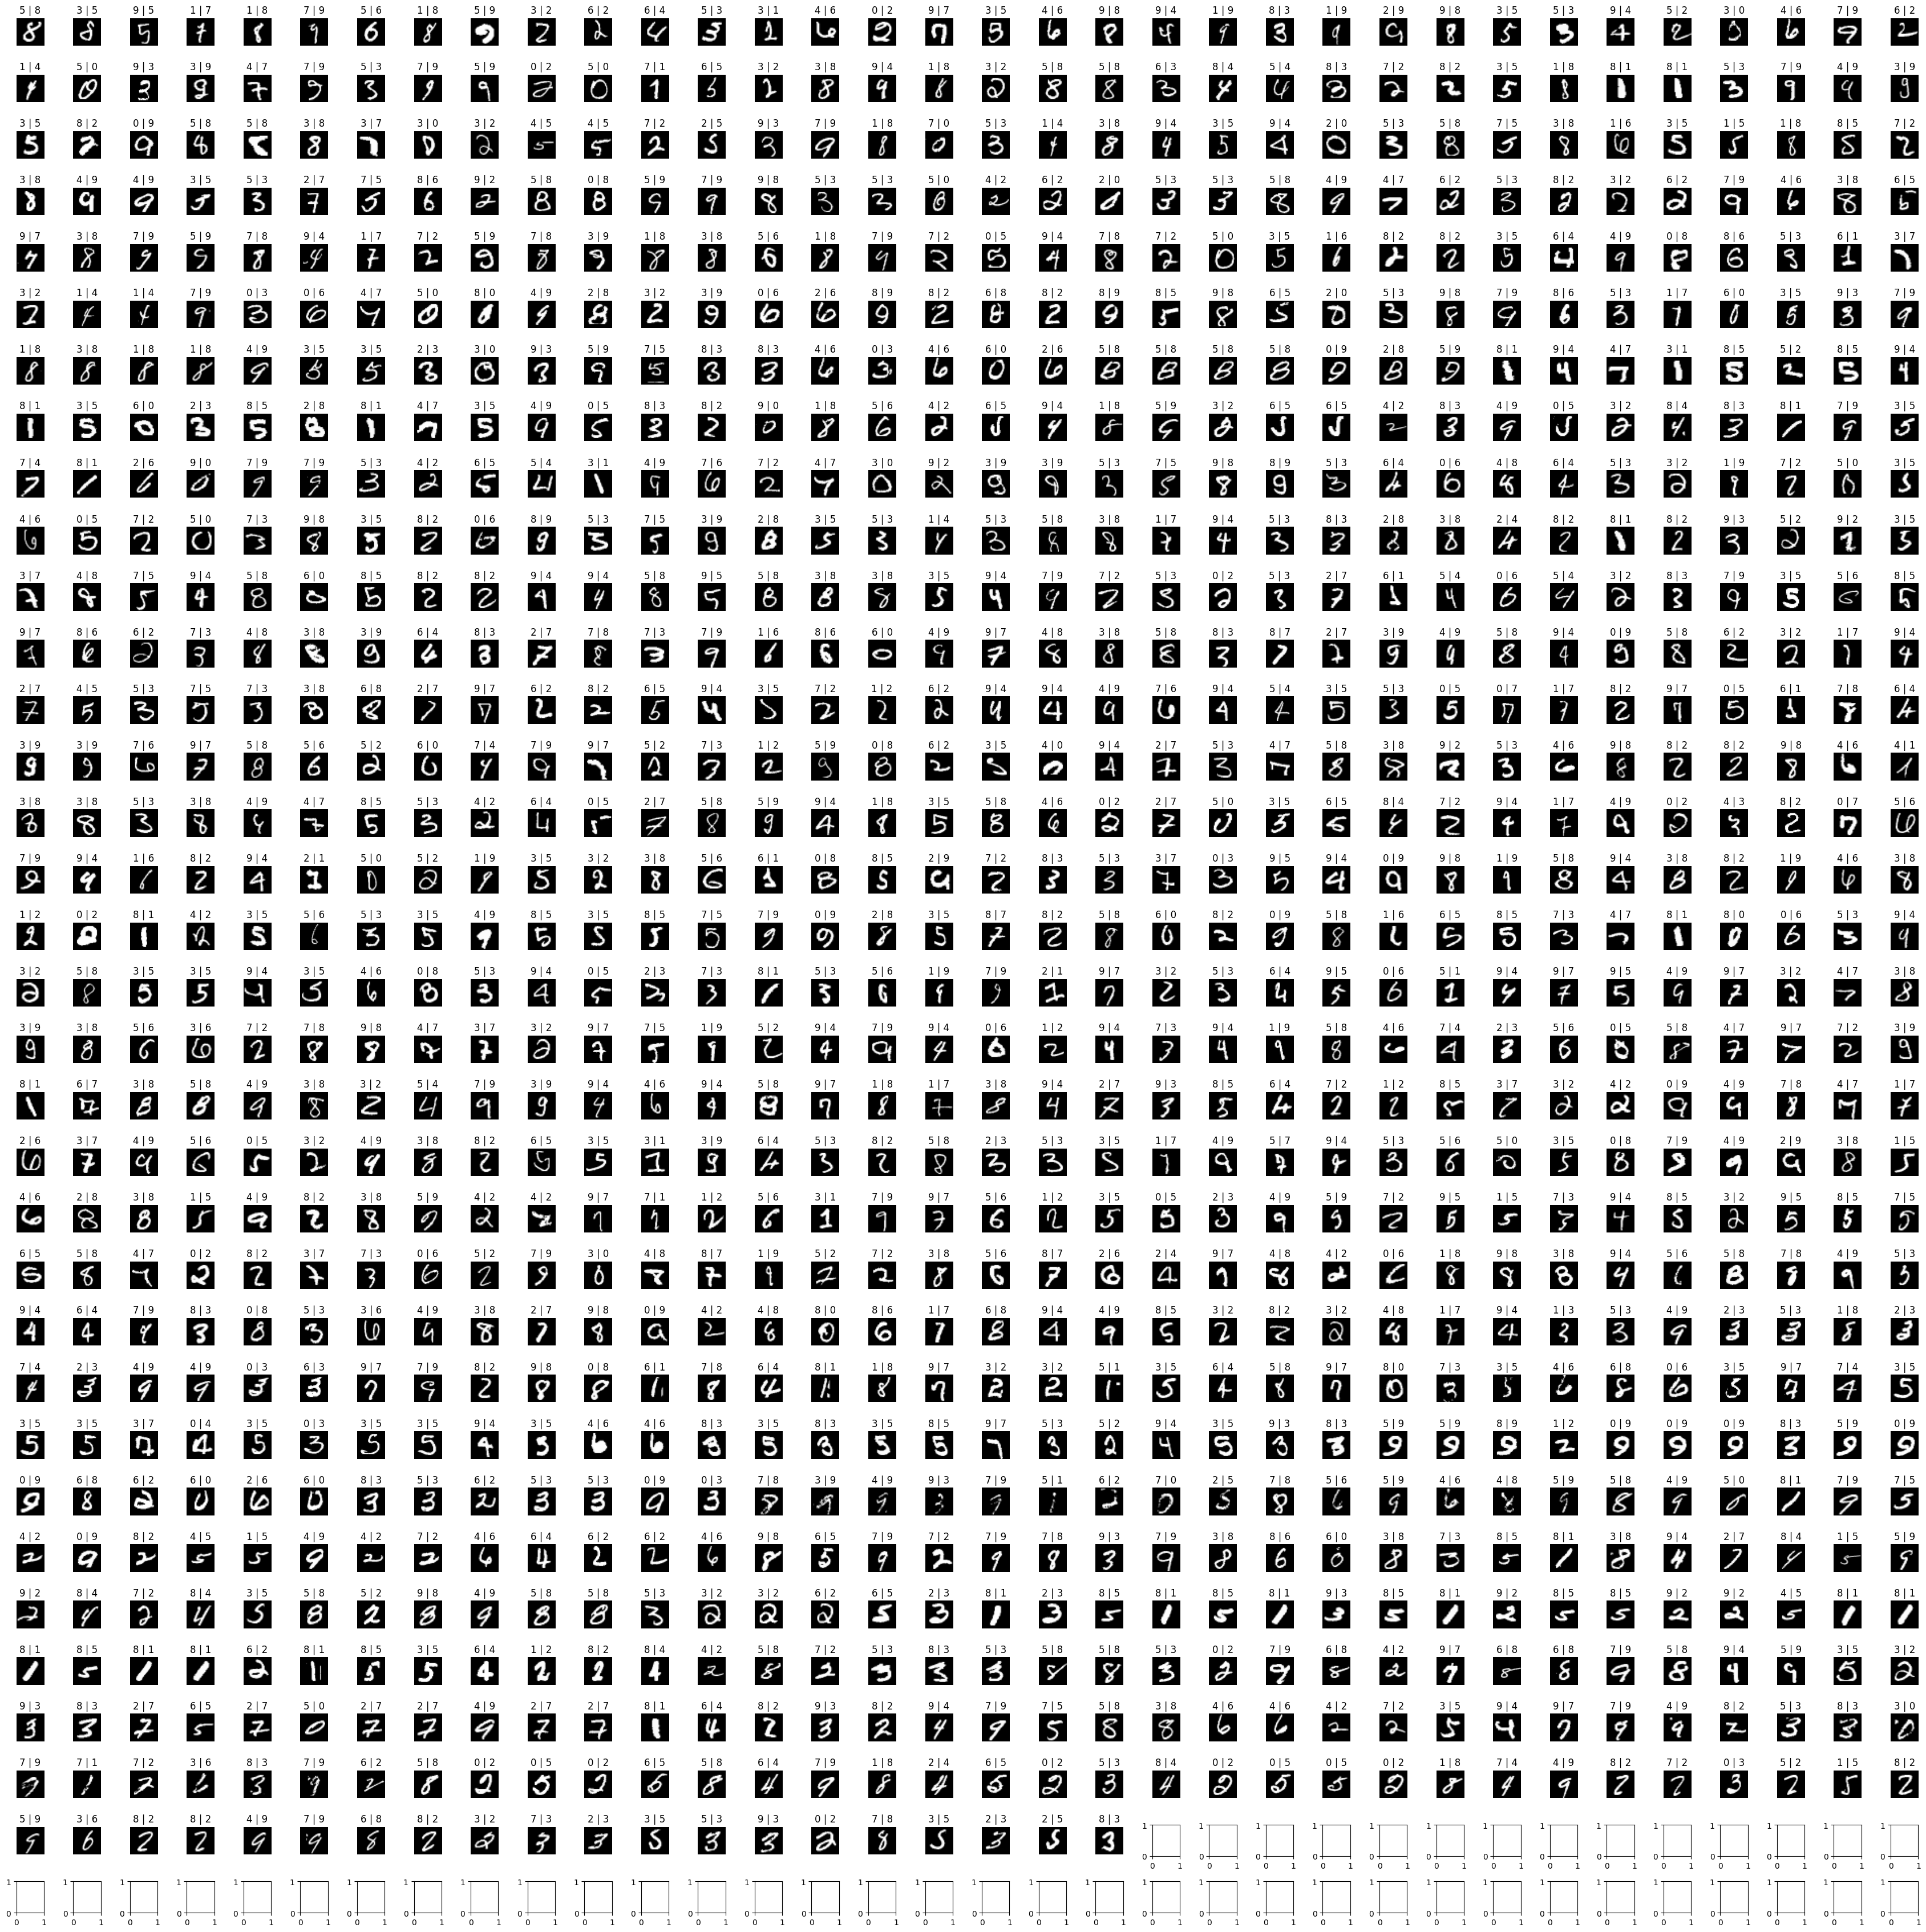

Total errors: 1108 out of 14000


In [14]:
# display errors in the predictions across the test set
DisplayErrors(X_test, y_test, predictions)

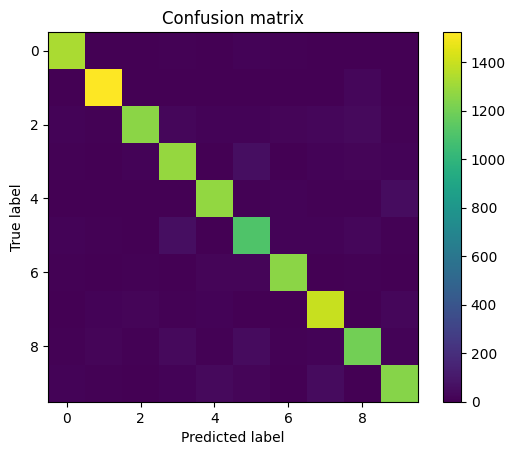

In [15]:
def DisplayConfusionMatrix(confusion_matrix: np.ndarray):
    """
    Display a confusion matrix as a heatmap.
    """
    plt.imshow(confusion_matrix, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()

# compute the confusion matrix
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(y_test, predictions, num_classes=10)
confusion_matrix = confusion_matrix.numpy()
DisplayConfusionMatrix(confusion_matrix)

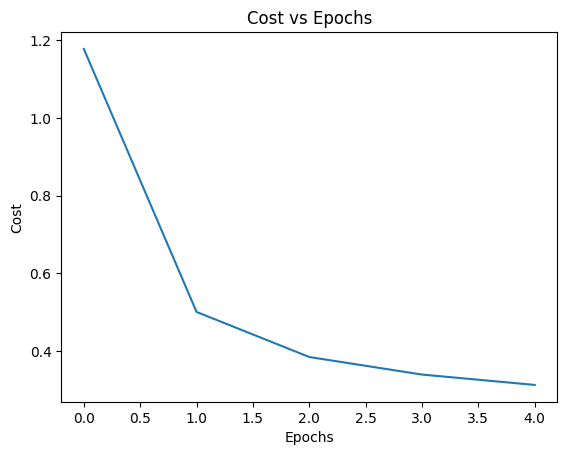

In [16]:
# cost vs epochs
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Epochs')
plt.show()

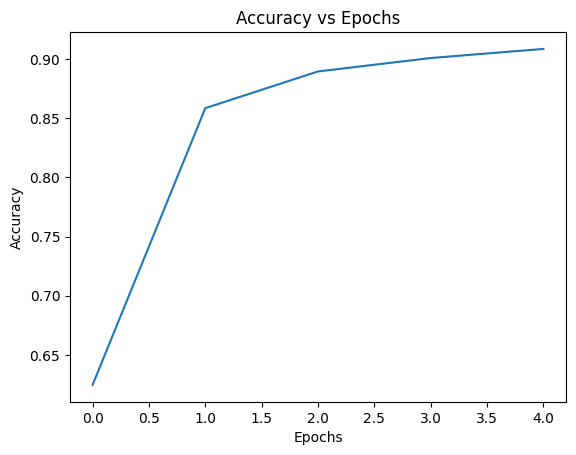

In [18]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()